# Imports

In [ ]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tabulate

import warnings
warnings.filterwarnings(action='ignore')

# Load Data

In [2]:
filepath = r'C:\Idan\OpenU\כריית מידע\mmn21\Chronic_Kidney_Disease\Chronic_Kidney_Disease\chronic_kidney_disease_full.arff'
data = []
with open(filepath, "r") as f:
    data = [line.strip().split(',') for line in f]

columns = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
           'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm',
           'cad', 'appet', 'pe', 'ane', 'class', 'to_delete']
# Data starts from 145 and end 2 lines before the end
ckd_df = pd.DataFrame(data[145:-2], columns=columns)
# drop 'to_delete' column
ckd_df = ckd_df.drop(['to_delete'] ,axis=1)

# Data Preparing

In [3]:
# Separate categorical and numeric columns
numeric_columns = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
categorical_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']

# Replace missing values with nan
ckd_df = ckd_df.replace({'?': np.nan,
                         'yes': 1, 'no': 0,
                         'ckd': 1, 'notckd': 0,
                         'good': 1, 'poor': 0,
                         'normal': 1, 'abnormal': 0,
                         'present': 1, 'notpresent': 0,
                         '' : np.nan})

# delete rows with more than 9 missing values (remove 11 rows)
ckd_df = ckd_df.dropna(thresh=9)

# Convert Numeric columns to numeric
ckd_df[numeric_columns] = ckd_df[numeric_columns].apply(pd.to_numeric)
# Convert categorical columns to category
ckd_df[categorical_columns] = ckd_df[categorical_columns].apply(lambda x: x.astype('category'))

# splitting the dataset to X and y
X = ckd_df.drop(['class'], axis=1)
y = ckd_df['class']

# remove 'class' from categorical columns
categorical_columns.remove('class')

# After view the Q-Q plot, we can see that there are some outliers in the data
# Remove outliers rows of each feature of numeric columns.
# After it, Use KnnImputer to reassign them again
X.loc[X['bp'] >= 180, 'bp'] = np.nan
X.loc[X['bu'] > 241, 'bu'] = np.nan
X.loc[X['sc'] >= 20, 'sc'] = np.nan
X.loc[X['sc'] >= 100, 'sod'] = np.nan
X.loc[X['sod'] > 150, 'sod'] = np.nan
X.loc[X['sod'] <= 104, 'sod'] = np.nan
X.loc[X['wc'] >= 16_700, 'wc'] = np.nan
X.loc[X['bgr'] < 70, 'bgr'] = np.nan

In [5]:
# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Data Preprocessing

In [6]:
# Use StandardScaler on numeric columns to scale them to be in the range of 0-1
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Use MinMaxScaler on numeric columns for mean and standard deviation normalization to mean=0 and std=1
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Impute missing values of numeric columns with KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
X_train[numeric_columns] = knn_imputer.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = knn_imputer.transform(X_test[numeric_columns])

# Use SimpleImputer to impute missing categorical features
simple_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_columns] = simple_imputer.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = simple_imputer.transform(X_test[categorical_columns])

# KBinsDiscretizer Explanation:
# Bin continuous data into intervals and transform them with ordinal encoding. (it's a Combination of binning and encoding)
# Parameters:
#            n_bins: The number of bins to produce.
#            encode='ordinal': Encode the transformed result with values between 0 and n_bins-1.
#            strategy='quantile': Equal depth binning. The quantile strategy produces bins that have the same number of records in each bin.
#            strategy='uniform': Equal width binning. The width of each bin is (max - min) / n_bins.
# Binning age column to 5 equal-depth bins
k_bins_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train['age'] = k_bins_discretizer.fit_transform(X_train[['age']])
X_test['age'] = k_bins_discretizer.transform(X_test[['age']])
# Binning numeric columns 3 bins with equal width
binning_columns_with_a_lot_of_values = ['bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
k_bins_discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
for col in binning_columns_with_a_lot_of_values:
    X_train[col] = k_bins_discretizer.fit_transform(X_train[[col]])
    X_test[col] = k_bins_discretizer.transform(X_test[[col]])

# Convert numeric columns to category
X_train[numeric_columns] = X_train[numeric_columns].apply(lambda x: x.astype('category'))
X_test[numeric_columns] = X_test[numeric_columns].apply(lambda x: x.astype('category'))

# Select K best features (score_func options are: f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression)
k_best = SelectKBest(k=15, score_func=f_classif)
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

# Grid Search for best parameters for Random Forest Classifier and AdaBoost Classifier

In [7]:
# Use grid_search to find the best parameters for random forest classifier
# import multiprocessing
# n_jobs = multiprocessing.cpu_count()
# print(f'Number of CPUs: {n_jobs}')
# rfc = RandomForestClassifier(random_state=1)
# param_grid = {'n_estimators': [80, 100, 200],
#               'min_samples_split': [2, 3, 4],
#               'max_depth': [3, 4, 5, 6, 7, 8],
#               'criterion': ['gini'],
#               'max_features': ['sqrt', 'log2']}
#
# grid_search = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy', verbose=n_jobs-1)
# grid_search.fit(X_train, y_train)
# print(param_grid)
# print(f'Best parameters: {grid_search.best_params_}')
# print(f'Best score: {grid_search.best_score_}')

# Use grid_search to find the best parameters for AdaBoost classifier
# model = AdaBoostClassifier(random_state=1)
# grid = {
#     'n_estimators': [500, 1000, 2000, 5000],
#     'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
# }
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=grid,
#                            cv=10,
#                            scoring='accuracy',
#                            verbose=5)
# print('Fit the grid search model...')
# grid_result = grid_search.fit(X_train, y_train)
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

##  Define functions for later

In [8]:
# Define a function to calculate the Mean Squared Error
def mean_squared_error(y_true, y_pred):
    # convert y_true to numeric type
    y_true = y_true.astype(np.float64)
    return np.mean((y_true - y_pred) ** 2)

# Define a function to display the ROC curve and calculate the AUC score
def plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, model_name):
    # Calculate ROC curves and AUC scores for both training and test sets
    # y_pred_proba_train = rfc_model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    auc_train = roc_auc_score(y_train, y_pred_proba_train)

    # y_pred_proba_test = rfc_model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    auc_test = roc_auc_score(y_test, y_pred_proba_test)

    # Plot the ROC curves for both training and test sets
    plt.plot(fpr_train, tpr_train, label=f"Training set, auc={auc_train}")
    plt.plot(fpr_test, tpr_test, label=f"Test set, auc={auc_test}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
    # Title
    plt.title(f'ROC Curve of {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# 1. Random Forest Classifier

In [9]:
# Define the best parameters for Random Forest Classifier
random_forest_best_params = {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80}
# Initialize the Random Forest Classifier
rfc_model = RandomForestClassifier(**random_forest_best_params, random_state=42)

## 1.1. Random Forest Classifier - 10-Fold cross validation

In [10]:
# Perform cross validation with 10 folds.
# Using a loop and not automatic function because I want to append the scores to few lists and display details of each fold
rfc_k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
rfc_k_fold.get_n_splits(X_train)
folds_y_tests, predictions_of_all_folds = [], []
train_scores, test_scores = [], []
confusion_matrix_list = []
for train_index, test_index in rfc_k_fold.split(X_train):
    # Define the train and test sets for each fold
    X_train_k_fold, X_test_k_fold = X_train[train_index], X_train[test_index]
    y_train_k_fold, y_test_k_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    # Fit the model and predict of current fold
    rfc_model.fit(X_train_k_fold, y_train_k_fold)
    # Calculate the scores on test set
    y_pred = rfc_model.predict(X_test_k_fold)
    # Append the y_test and y_pred to the lists for the classification report
    folds_y_tests.extend(y_test_k_fold)
    predictions_of_all_folds.extend(y_pred)
    # Append the scores to the lists
    train_scores.append(rfc_model.score(X_train_k_fold, y_train_k_fold))
    test_scores.append(rfc_model.score(X_test_k_fold, y_test_k_fold))
    confusion_matrix_list.append(confusion_matrix(y_test_k_fold, y_pred))

print('Random Forest Classifier 10-Cross Validation Results:')
# print the train and test scores with a column of the number of fold
print(tabulate.tabulate({'Fold': range(1, 11),
                         'Train scores': train_scores,
                         'Test scores': test_scores}, headers='keys', tablefmt='psql'))

# Print the mean of the train and test scores
print(f'Mean train score: {np.mean(train_scores)}')
print(f'Mean test score: {np.mean(test_scores)}')

# Sum all the confusion matrices from the cross validation
confusion_matrix_sum = np.sum(confusion_matrix_list, axis=0)

# Print the confusion matrix with tabulate
print('Confusion Matrix:')
print(tabulate.tabulate({'': ['Actual Positive', 'Actual Negative'],
                            'Predicted Positive': [confusion_matrix_sum[0][0], confusion_matrix_sum[0][1]],
                            'Predicted Negative': [confusion_matrix_sum[1][0], confusion_matrix_sum[1][1]]},
                            headers='keys',
                            tablefmt='psql'))

# Print the classification report for the sum of the folds predictions
print('Classification Report of all folds:')
print(classification_report(folds_y_tests, predictions_of_all_folds))

Random Forest Classifier 10-Cross Validation Results:
+--------+----------------+---------------+
|   Fold |   Train scores |   Test scores |
|--------+----------------+---------------|
|      1 |       0.989583 |       1       |
|      2 |       0.989583 |       1       |
|      3 |       0.989583 |       1       |
|      4 |       0.989583 |       1       |
|      5 |       0.989583 |       1       |
|      6 |       0.996528 |       0.9375  |
|      7 |       0.989583 |       1       |
|      8 |       0.996528 |       0.96875 |
|      9 |       0.989583 |       1       |
|     10 |       0.993056 |       1       |
+--------+----------------+---------------+
Mean train score: 0.9913194444444444
Mean test score: 0.990625
Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  121 |         

## 1.2. Random Forest Classifier - Predict the test set

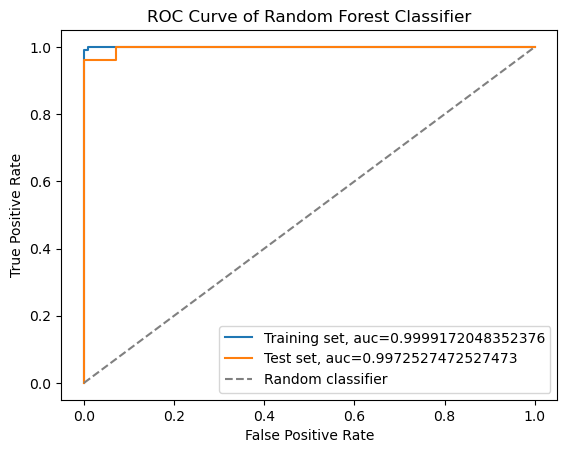

Mean Squared Error: 0.025
Test score: 0.975


In [11]:
from sklearn.metrics import accuracy_score

# Fit the model on the train set to evaluate the model on the test set (not cross validation)
rfc_model.fit(X_train, y_train)
# Display the ROC curve of the Random Forest Classifier for comparing between the train and test sets
# predict_proba returns an array with 2 columns:
# the first is the probability of the negative class
# the second is the probability of the positive class
y_pred_proba_train = rfc_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = rfc_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, 'Random Forest Classifier')

# Predict the test set
y_pred = rfc_model.predict(X_test)
# Calculate and print the Mean Squared Error of the cross validation
mse_rfc = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_rfc}')

# print test score of the test set (not cross validation)
print(f'Test score: {rfc_model.score(X_test, y_test)}')

# 2. AdaBoost Classifier

In [12]:
# Define the best parameters for AdaBoost Classifier
ada_boost_best_params = {'learning_rate': 0.001, 'n_estimators': 25} # was 0.001, 2000
# Initialize the AdaBoost Classifier
ada_boost_model = AdaBoostClassifier(**ada_boost_best_params, random_state=42)

# 2.1. AdaBoost Classifier - 10-Fold cross validation

In [13]:
# Perform cross validation with 10 folds with sklearn class
ada_boost_k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
ada_boost_k_fold.get_n_splits(X_train)
folds_y_tests, predictions_of_all_folds = [], []
train_scores, test_scores = [], []
confusion_matrix_list = []
for train_index, test_index in ada_boost_k_fold.split(X_train):
    # Define the train and test sets for each fold
    X_train_k_fold, X_test_k_fold = X_train[train_index], X_train[test_index]
    y_train_k_fold, y_test_k_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    # Fit the model and predict of current fold
    ada_boost_model.fit(X_train_k_fold, y_train_k_fold)
    # Calculate the scores on test set
    y_pred = ada_boost_model.predict(X_test_k_fold)
    # Append the y_test and y_pred to the lists for the classification report
    folds_y_tests.extend(y_test_k_fold)
    predictions_of_all_folds.extend(y_pred)
    # Append the scores to the lists
    train_scores.append(ada_boost_model.score(X_train_k_fold, y_train_k_fold))
    test_scores.append(ada_boost_model.score(X_test_k_fold, y_test_k_fold))
    confusion_matrix_list.append(confusion_matrix(y_test_k_fold, y_pred))


print('AdaBoost 10-Cross Validation Results:')
# print the train and test scores with a column of the number of fold
print(tabulate.tabulate({'Fold': range(1, 11),
                         'Train scores': train_scores,
                         'Test scores': test_scores}, headers='keys', tablefmt='psql'))

# Print the mean of the train and test scores

# Print the mean of the train and test scores
print(f'Mean train score: {np.mean(train_scores)}')
print(f'Mean test score: {np.mean(test_scores)}')

# Sum all the confusion matrices from the cross validation
confusion_matrix_sum = np.sum(confusion_matrix_list, axis=0)

# Print the confusion matrix with tabulate
print('Confusion Matrix:')
print(tabulate.tabulate({'': ['Actual Positive', 'Actual Negative'],
                            'Predicted Positive': [confusion_matrix_sum[0][0], confusion_matrix_sum[0][1]],
                            'Predicted Negative': [confusion_matrix_sum[1][0], confusion_matrix_sum[1][1]]},
                            headers='keys',
                            tablefmt='psql'))



# Print the classification report for the sum of the folds predictions
print('Classification Report of all folds:')
print(classification_report(folds_y_tests, predictions_of_all_folds))

AdaBoost 10-Cross Validation Results:
+--------+----------------+---------------+
|   Fold |   Train scores |   Test scores |
|--------+----------------+---------------|
|      1 |       0.982639 |       1       |
|      2 |       0.982639 |       1       |
|      3 |       0.986111 |       0.96875 |
|      4 |       0.982639 |       1       |
|      5 |       0.982639 |       1       |
|      6 |       0.989583 |       0.9375  |
|      7 |       0.913194 |       0.875   |
|      8 |       0.986111 |       0.96875 |
|      9 |       0.982639 |       1       |
|     10 |       0.986111 |       0.96875 |
+--------+----------------+---------------+
Mean train score: 0.9774305555555556
Mean test score: 0.971875
Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  121 |                    8 |
|

# 2.2. AdaBoost Classifier - Predict the test set

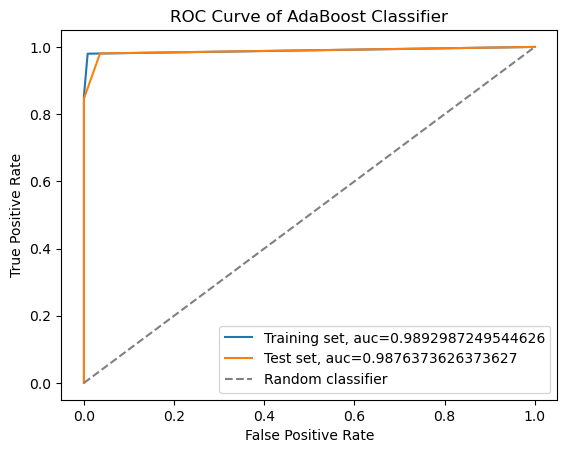

Mean Squared Error: 0.025
Test score: 0.975


In [14]:
# Display the ROC curve of the AdaBoost Classifier for comparing between the train and test sets
ada_boost_model.fit(X_train, y_train)
y_pred_proba_train = ada_boost_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = ada_boost_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, 'AdaBoost Classifier')

# Predict the test set
y_pred = ada_boost_model.predict(X_test)

# Calculate the Mean Squared Error of the cross validation
mse_adaboost = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mean_squared_error(y_test, ada_boost_model.predict(X_test))}')

# print test score of the test set (not cross validation)
print(f'Test score: {ada_boost_model.score(X_test, y_test)}')

# 3. Shhhh... don't tell anyone but... Bonus model: Naive Bayes Classifier !

In [15]:
from sklearn.naive_bayes import GaussianNB

# Grid Search for the best parameters for Naive Bayes Classifier

In [16]:
# # Search for the best parameters for Naive Bayes Classifier
# nb_classifier = GaussianNB()
#
# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
# gs_NB = GridSearchCV(estimator=nb_classifier,
#                  param_grid=params_NB,
#                  cv=10,
#                  verbose=1,
#                  scoring='accuracy')
# gs_NB.fit(X_train, y_train)
# gs_NB.best_params_

# 3.1. Naive Bayes Classifier - 10-Fold Cross Validation

In [17]:
# Initialize the Naive Bayes Classifier
naive_bayes_model = GaussianNB(var_smoothing=0.004328761281083057)

# Perform cross validation with 10 folds with sklearn class
naive_bayes_k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
naive_bayes_k_fold.get_n_splits(X_train)
folds_y_tests, predictions_of_all_folds = [], []
train_scores, test_scores = [], []
confusion_matrix_list = []
for train_index, test_index in naive_bayes_k_fold.split(X_train):
    # Define the train and test sets for each fold
    X_train_k_fold, X_test_k_fold = X_train[train_index], X_train[test_index]
    y_train_k_fold, y_test_k_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    # Fit the model and predict of current fold
    naive_bayes_model.fit(X_train_k_fold, y_train_k_fold)
    # Calculate the scores on test set
    y_pred = naive_bayes_model.predict(X_test_k_fold)
    # Append the y_test and y_pred to the lists for the classification report
    folds_y_tests.extend(y_test_k_fold)
    predictions_of_all_folds.extend(y_pred)
    # Append the scores to the lists
    train_scores.append(naive_bayes_model.score(X_train_k_fold, y_train_k_fold))
    test_scores.append(naive_bayes_model.score(X_test_k_fold, y_test_k_fold))
    confusion_matrix_list.append(confusion_matrix(y_test_k_fold, y_pred))

# Print the train and test scores with a column of the number of fold
print('Naive Bayes 10-Cross Validation Results:')
print(tabulate.tabulate({'Fold': range(1, 11),
                         'Train scores': train_scores,
                         'Test scores': test_scores}, headers='keys', tablefmt='psql'))

# Print the mean of the train and test scores
print(f'Mean train score: {np.mean(train_scores)}')
print(f'Mean test score: {np.mean(test_scores)}')

# Sum all the confusion matrices from the cross validation
confusion_matrix_sum = np.sum(confusion_matrix_list, axis=0)

# Print the confusion matrix with tabulate
print('Confusion Matrix:')
print(tabulate.tabulate({'': ['Actual Positive', 'Actual Negative'],
                            'Predicted Positive': [confusion_matrix_sum[0][0], confusion_matrix_sum[0][1]],
                            'Predicted Negative': [confusion_matrix_sum[1][0], confusion_matrix_sum[1][1]]},
                            headers='keys',
                            tablefmt='psql'))

# Print the classification report for the sum of the folds predictions
print('Classification Report of all folds:')
print(classification_report(folds_y_tests, predictions_of_all_folds))

Naive Bayes 10-Cross Validation Results:
+--------+----------------+---------------+
|   Fold |   Train scores |   Test scores |
|--------+----------------+---------------|
|      1 |       0.996528 |       1       |
|      2 |       0.996528 |       1       |
|      3 |       0.996528 |       1       |
|      4 |       0.996528 |       1       |
|      5 |       0.996528 |       1       |
|      6 |       1        |       0.96875 |
|      7 |       0.996528 |       1       |
|      8 |       0.996528 |       1       |
|      9 |       0.996528 |       1       |
|     10 |       0.996528 |       1       |
+--------+----------------+---------------+
Mean train score: 0.9968750000000002
Mean test score: 0.996875
Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  121 |                    0 

# 3.2. Naive Bayes Classifier - Predict the test set

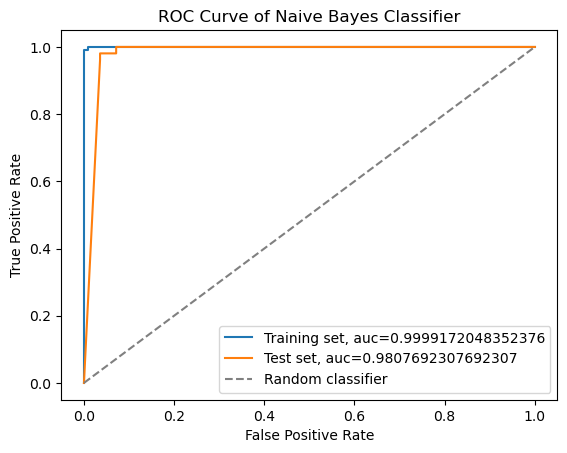

Mean Squared Error: 0.025
Test score: 0.975


In [18]:
# Display the ROC curve of the Naive Bayes Classifier for comparing between the train and test sets
naive_bayes_model.fit(X_train, y_train)
y_pred_proba_train = naive_bayes_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = naive_bayes_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, 'Naive Bayes Classifier')

# Predict the test set
y_pred = naive_bayes_model.predict(X_test)

# Calculate the Mean Squared Error of the cross validation
mse_naive_bayes = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mean_squared_error(y_test, naive_bayes_model.predict(X_test))}')

# print test score of the test set (not cross validation)
print(f'Test score: {naive_bayes_model.score(X_test, y_test)}')

# 4. Summary of the models

In [19]:
# Create a dataframe of the models and their scores
models_df = pd.DataFrame({'Model': ['Random Forest', 'AdaBoost', 'Naive Bayes'],
                          'Mean Squared Error': [mse_rfc, mse_adaboost, mse_naive_bayes],
                          'Test Score': [rfc_model.score(X_test, y_test), ada_boost_model.score(X_test, y_test), naive_bayes_model.score(X_test, y_test)]})
# Print the dataframe
print(tabulate.tabulate(models_df, headers='keys', tablefmt='psql'))



+----+---------------+----------------------+--------------+
|    | Model         |   Mean Squared Error |   Test Score |
|----+---------------+----------------------+--------------|
|  0 | Random Forest |                0.025 |        0.975 |
|  1 | AdaBoost      |                0.025 |        0.975 |
|  2 | Naive Bayes   |                0.025 |        0.975 |
+----+---------------+----------------------+--------------+
